# Coupled Transmon / LC-oscillator (without the GUI)

The first step is to import the objects we will be needing from Qcircuits

In [1]:
# Import the circuit builder
from Qcircuits import Network
# Import the circuit components
from Qcircuits import L,J,C,R

import numpy as np

## Building the circuit

Note that the components (``R``, ``L``, ``C``, ``J``) accept node indexes as their two 
first arguments, 
here we will use the node ``0`` to designate ground. The last arguments should be 
a label (``str``) or a value (``float``) or both, the order in which these
arguments are provided are unimportant.

For the moment, we will specify the value of all the components

In [33]:
circuit = Network([
    C(0,1,100e-15),
    J(0,1,8e-9),
    C(1,2,1e-15),
    C(2,0,100e-15),
    L(2,0,10e-9),
    R(2,0,1e6)
])

This implements the following circuit, where we have also indexed the nodes, and we have fixed the value of $L_J$ to ``8e-9``

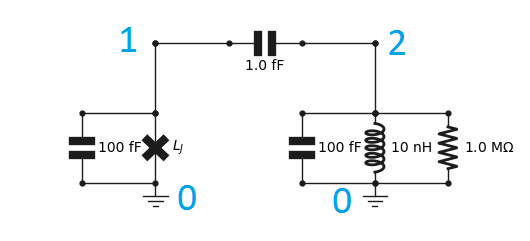

In [34]:
from IPython.display import Image
Image("graphics/transmon_LC_programmatically_1.png")

We now calculate the eigenfrequency, loss-rates, anharmonicity, and Kerr parameters of the circuit. 

This can be done through the functions ``eigenfrequencies``, ``loss_rates``, ``anharmonicities`` and ``kerr``, which return the specified quantities for each mode, **ordered with increasing mode frequency**

## Calculating circuit parameters

### Eigen-frequencies

In [35]:
circuit.eigenfrequencies()

array([5.00696407e+09, 5.60042136e+09])

This will return a list of the normal modes of the circuit, we can see they are seperated in frequency by 600 MHz, but we still do not which corresponds to the transmon, and which to the resonator.

To distinquish the two, we can calculate the anharmonicities of each mode.

### Anharmonicity

In [36]:
circuit.anharmonicities()

array([5.83759906e+02, 1.91131052e+08])

The first (lowest frequency) mode, has a very small anharmonicity, whilst the second, has an anharmonicity of 191 MHz. The highest frequency mode thus corresponds to the transmon.

### Cross-Kerr or dispersive shift

In this regime of far detuning in frequency, the two modes will interact through a cross-Kerr or dispersive shift, which quantifies the amount by which one mode will shift if frequency if the other is populated with a photon.

We can access this by calculating the Kerr parameters.

In [37]:
K = circuit.kerr()
K[0,1]

668055.8212288042

In this two dimensional array, the components ``K[i,j]`` correspond to the cross-Kerr interaction of mode ``i`` with mode ``j``. From the above, we have found that the cross-Kerr interaction between these two modes is of about 670 kHz.

This should correspond to $2\sqrt{A_0A_1}$ where $A_i$ is the anharmonicity of mode $i$

In [38]:
A = circuit.anharmonicities()
2*np.sqrt(A[0]*A[1])

668055.8212288042

### Loss rates

In the studied circuit, the only resistor is located in the resonator. In this regime of large frequency, detuning, we would thus expect the resonator to be more lossy than the transmon.

In [39]:
circuit.loss_rates()

array([786052.42260112,   1920.57996169])

All these relevant parameters can be computed using a single function

In [40]:
circuit.f_k_A_chi()

(array([5.00696407e+09, 5.60042136e+09]),
 array([786052.42260112,   1920.57996169]),
 array([5.83759906e+02, 1.91131052e+08]),
 array([[5.83759906e+02, 6.68055821e+05],
        [6.68055821e+05, 1.91131052e+08]]))

And using the option ``pretty_print = True`` a more readable summary can be printed

In [41]:
f,k,A,chi = circuit.f_k_A_chi(pretty_print=True)

    mode |  freq.  |  diss.  |  anha.  |
       0 | 5.0 GHz | 786 kHz |  584 Hz |
       1 | 5.6 GHz | 1.9 kHz | 191 MHz |

Kerr coefficients
(diagonal = Kerr, off-diagonal = cross-Kerr)
    mode |    0    |    1    |
       0 |  584 Hz |         |
       1 | 668 kHz | 191 MHz |



## Hamiltonian, and further analysis with QuTiP

### Generating a Hamiltonian

The Hamiltonian of the circuit, with the non-linearity of the Josephson junctions
Taylor-expanded, is given by

\begin{equation}
\hat{H} = \sum_{m\in\text{modes}} hf_m\hat{a}_m^\dagger\hat{a}_m +\sum_j\sum_{2n\le\text{taylor}}E_j\frac{(-1)^{n+1}}{(2n)!}\left(\frac{\phi_{zpf,m,j}}{\phi_0}(\hat{a}_m^\dagger+\hat{a}_m)\right)^{2n}
\end{equation}

And in its construction, we have the freedom to choose the set of ``modes`` to include, the order of the Taylor expansion of the junction potential, and the number of excitations of each mode to consider.

In [42]:
# Compute hamiltonian (for h=1, so all energies are expressed in frequency units, not angular)
H = circuit.hamiltonian(modes = [0,1],taylor = 4,excitations = [10,10])

# QuTiP method which return the eigenergies of the system
ee = H.eigenenergies()

The first transition of the resonator is

In [43]:
ee[1]-ee[0]

5006408876.608672

and of the transmon

In [44]:
ee[2]-ee[0]

5393689685.854876

Notice the difference, especially for the transmon, with the corresponding normal-mode frequency calculated above. This is a consequence of the zero-point fluctuations entering the junction and changing the effective transition frequency.

Following first-order perturbation frequency, the shift in transition frequency can be estimated from the anharmonicity $A_1$ and cross-kerr coupling $\chi_{0,1}$ and should be given by $-A_1-\chi_{0,1}/2$. We see below that we get fairly close (7 MHz) from the value obtained from the hamiltonian diagonalization.

In [45]:
f,k,A,K = circuit.f_k_A_chi()
f[1]-A[1]-K[0,1]/2

5408956281.581059

### Open-system dynamics

A more elaborate use of QuTiP would be to compute the dynamics, for example the decay of the transmon initially populated in its excited state (T1 process).

## Sweeping a parameter: the avoided crossing

We will only provide a label ``L_J`` for the junction here, 
and its value should be passed
as a keyword argument in subsequent function calls,
for example ``L_J=1e-9``. 

In [ ]:
# Since the junction was created without a value, 
# we now have to specify it